# Librerias Random Forest regresión:

In [17]:
# Tratamiento de datos
import numpy as np
import pandas as pd


# Gráficos

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8


# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed, cpu_count
import optuna


# Configuración warnings
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"Versión de scikit-learn: {sklearn.__version__}")

Versión de scikit-learn: 1.4.0


In [10]:
# Cargar la base de datos
Boston = pd.read_csv('Boston.csv')

# Reto: 
La base de Dato contiene precios de viviendas de la ciudad de Boston, así como información socio-económica del barrio en el que se encuentran. Se pretende ajustar un modelo de regresión que permita predecir el precio medio de una vivienda (MEDV) en función de las variables disponibles.

In [14]:
print(Boston.head())
print(Boston.info())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

   LSTAT  MEDV  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4   5.33  36.2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE

 El set de datos Boston contiene precios de viviendas de la ciudad de Boston, así como información socio-económica del barrio en el que se encuentran. Se pretende ajustar un modelo de regresión que permita predecir el precio medio de una vivienda (MEDV) en función de las variables disponibles.

Número de instancias: 506

Número de atributos: 13 predictivos numéricos/categoriales.

Información de los atributos (por orden):

* CRIM: tasa de delincuencia per cápita por ciudad.

* ZN: proporción de suelo residencial dividido para segmentos de más de 25.000 pies cuadrados.

* INDUS: proporción de superficie comerciales no minoristas por ciudad.

* CHAS: variable binaria sobre el río Charles (= 1 si la zona linda con el río; 0 en caso contrario).

* NOX: concentración de óxidos nítricos (partes por 10 millones).

* RM: número medio de habitaciones por vivienda.

* EDAD: proporción de viviendas ocupadas construidas antes de 1940.

* DIS: distancia ponderada a cinco centros de empleo en la ciudad de Boston.

* RAD: índice de accesibilidad a las autopistas radiales.

* TAX: impuesto sobre bienes inmuebles de valor íntegro por cada 10.000$.

* PTRATIO: ratio alumnos-profesor por ciudad.

* LSTAT: % de la población considerado de clase baja.

* MEDV: valor medio de las viviendas ocupadas por sus propietarios en miles de $.

Valores ausentes: Ninguno

Ajuste del modelo
Se ajusta un modelo empleando como variable respuesta MEDV y como predictores todas las otras variables disponibles

In [13]:
# División de los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
                                        Boston.drop(columns="MEDV"),
                                        Boston['MEDV'],
                                        test_size = 0.25,
                                        random_state = 123
                                    )

print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tamaño conjunto test: {X_test.shape[0]}")

# Creación del modelo

modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo

modelo.fit(X_train, y_train)

Tamaño conjunto entrenamiento: 379
Tamaño conjunto test: 127


RandomForestRegressor(max_features=1, n_estimators=10, n_jobs=-1,
                      random_state=123)

El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de RandomForestRegressor, la métrica devuelta como oob_score es el  R2
 , si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

# Predicción y evaluación del modelo

Teniendo el modelo, se evalúa la capacidad predictiva empleando el conjunto de test.

In [15]:
# Error de test del modelo inicial

predicciones = modelo.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 4.17800427058654


# Número de árboles 

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.

Valor óptimo de n_estimators: 66


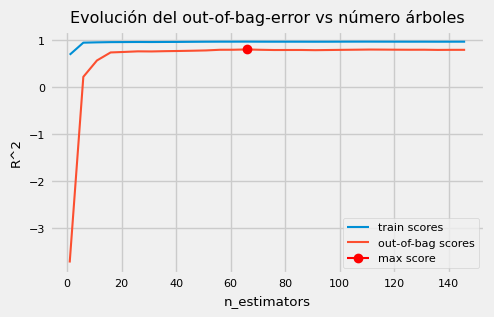

In [18]:
# Validación empleando el Out-of-Bag error

warnings.filterwarnings('ignore')
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")
warnings.filterwarnings('default')

c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38:

Valor óptimo de n_estimators: 96


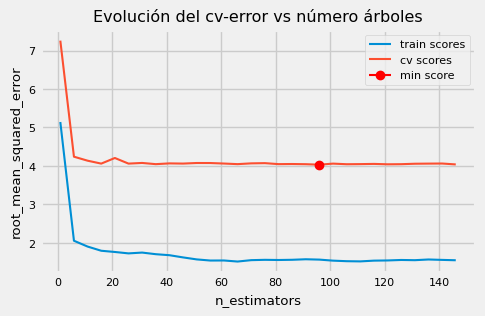

In [33]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error

train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de entrenamiento
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X=X_train)
    rmse = root_mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Si bien el valor óptimo de las métricas se alcanza con 66 y 96 árboles, las curvas indican que, a partir de 20 árboles, el error de validación del modelo se estabiliza.


# Max features


El valor de máx_features es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38:

Valor óptimo de max_features: 4


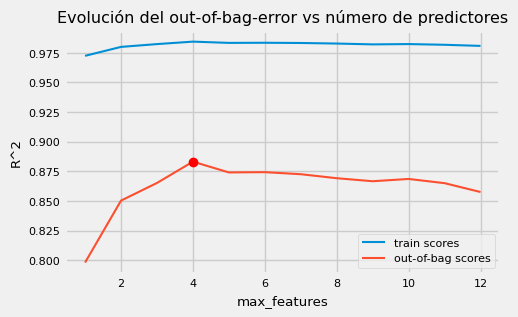

In [34]:
# Validación empleando el Out-of-Bag error

train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38:

Valor óptimo de max_features: 6


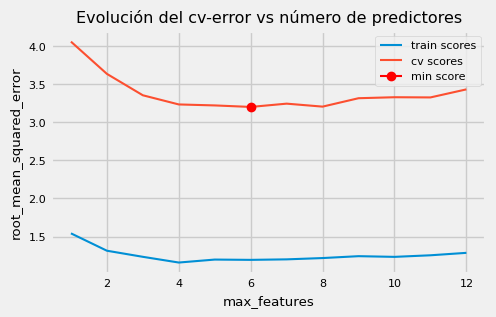

In [35]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error

train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = root_mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Acorde a las dos métricas utilizadas, el valor óptimo de max_features está entre 4 y 6.

# Grid search

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search, random search o bayesian search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

In [24]:
# Grid de hiperparámetros evaluados

param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros

resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

# Resultados

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓


c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
6,0.882461,10.0,5.0,150.0
0,0.875289,NaN,5.0,150.0
9,0.874590,20.0,5.0,150.0
10,0.874318,20.0,7.0,150.0


Este proceso de búsqueda puede paralelizarse para aprovechar todos cores del ordenador.

In [25]:
# Grid de hiperparámetros evaluados

param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros

def eval_oob_error(X, y, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params            
            )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} ✓")
        
    return{'params': params, 'oob_r2': modelo.oob_score_}

resultados = Parallel(n_jobs=cpu_count()-1)(
                delayed(eval_oob_error)(X_train, y_train, params)
                for params in param_grid
             )

# Resultados

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


,oob_r2,max_depth,max_features,n_estimators
6,0.882461,10.0,5.0,150.0
0,0.875289,NaN,5.0,150.0
9,0.874590,20.0,5.0,150.0
10,0.874318,20.0,7.0,150.0


In [27]:
# Mejores hiperparámetros por out-of-bag error

print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0:])

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
oob_r2            0.882461
max_depth        10.000000
max_features      5.000000
n_estimators    150.000000
Name: 6, dtype: float64


 Warning

La busqueda de hiperparámetros debe hacerse utilizando datos que el modelo no ha visto. Si se emplean los mismos datos para ajustar el modelo y para evaluarlo, se corre el riesgo de sobreajustar el modelo a los datos de entrenamiento. Para evitar este problema se puede recurrir a dos estrategias:

Dividir el conjunto de datos en tres grupos: entrenamiento, validación y test. El conjunto de entrenamiento se emplea para ajustar el modelo, el de validación para seleccionar el valor óptimo de los hiperparámetros y el de test para evaluar la capacidad predictiva del modelo.

Utilizar validación cruzada con los datos de entrenamiento. En este caso, el conjunto de entrenamiento se divide en k grupos y se ajusta el modelo k veces, cada vez con un grupo distinto como conjunto de validación. La métrica final es el promedio de los valores obtenidos en cada iteración. Esta estrategia es computacionalmente más costosa, ya que requiere entrenar el modelo k veces, pero evita tener que crear una partición adicional de los datos cuando no se dispone de muchos.

In [29]:
# Grid de hiperparámetros evaluados

param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada

grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X=X_train, y=y_train)

# Resultados

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
6,10,5,150,-3.320295,0.701794,-1.323499,0.061678
7,10,7,150,-3.333357,0.696114,-1.327214,0.066324
0,None,5,150,-3.334407,0.715278,-1.261911,0.058096
9,20,5,150,-3.336755,0.716904,-1.261439,0.057603


In [30]:
# Mejores hiperparámetros encontrados mediante validación cruzada

print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 10, 'max_features': 5, 'n_estimators': 150} : -3.320294830700744 neg_root_mean_squared_error


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [31]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X=X_test)
rmse = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3.550875871674505


Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 4.35 a 3.55. Las predicciones del modelo final se alejan en promedio 3.55 unidades (3550 dólares) del valor real.

# Biblografiía:

Random Forest con Python por Joaquín Amat Rodrigo, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py08_random_forest_python.html